### Carregamento das Bibliotecas e Dados

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import os
import sys

# Adicionar pasta utils ao path
sys.path.append('./utils')
from generos_onehot import carregar_ou_processar_generos, obter_colunas_generos_limpos

# Configurar paths
INPUT_DATA_PATH = './datas/'
OUTPUT_PATH = './outputs/'
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [ ]:
df_generos = carregar_ou_processar_generos()

# Preparar matriz de gêneros para detecção de outliers usando função utilitária
colunas_generos = obter_colunas_generos_limpos(df_generos)
X = df_generos[colunas_generos].values
print(f"Quantidade de gêneros: {len(colunas_generos)}")
print(f"Gêneros incluídos: {colunas_generos}")

Carregando arquivo processado: ./datas/generos_onehot.csv
Dados carregados: (20237, 19)
Nenhum gênero adulto encontrado para remover.
Nenhum gênero adulto encontrado para remover.
Quantidade de gêneros: 16
Gêneros incluídos: ['Action', 'Adventure', 'Avant Garde', 'Award Winning', 'Comedy', 'Drama', 'Fantasy', 'Gourmet', 'Horror', 'Mystery', 'Romance', 'Sci-Fi', 'Slice of Life', 'Sports', 'Supernatural', 'Suspense']


### Padronização dos Dados

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Shape dos dados padronizados: {X_scaled.shape}")
print(f"Média após padronização: {X_scaled.mean():.6f}")
print(f"Desvio padrão após padronização: {X_scaled.std():.6f}")

Shape dos dados padronizados: (20237, 16)
Média após padronização: -0.000000
Desvio padrão após padronização: 1.000000


### Treinamento do One-Class SVM

O One-Class SVM consegue identificar animes com combinações de gêneros extremamente raras ou únicas, revelando obras que se destacam dos padrões convencionais da indústria anime, os quais chamaremos de `Nicho`.

O algoritmo treina apenas com dados "normais", não necessitando de exemplos de outliers; cria uma fronteira que separa a região normal do resto do espaço;Classifica novos pontos como normais (1) ou anômalos (-1)

In [ ]:
# Treinar One-Class SVM para detectar outliers
## nu controla a fração esperada de outliers (0.05 = 5% dos dados)
## kernel='rbf': Permite capturar padrões complexos e não-lineares
nu_value = 0.05
oc_svm = OneClassSVM(nu=nu_value, kernel='rbf', gamma='scale')
oc_svm.fit(X_scaled)

# Predizer outliers (-1) e inliers (1)
predictions = oc_svm.predict(X_scaled)
decision_scores = oc_svm.decision_function(X_scaled)

print(f"Total de animes: {len(predictions)}")
print(f"Animes normais (inliers): {sum(predictions == 1)}")
print(f"Animes de nicho (outliers): {sum(predictions == -1)}")
print(f"Percentual de outliers: {sum(predictions == -1) / len(predictions) * 100:.2f}%")

Total de animes: 20237
Animes normais (inliers): 19038
Animes de nicho (outliers): 1199
Percentual de outliers: 5.92%


### Análise dos Animes de Nicho Detectados

In [ ]:
# Adicionar predições ao dataframe
df_generos['is_outlier'] = predictions == -1
df_generos['decision_score'] = decision_scores
animes_nicho = df_generos[df_generos['is_outlier'] == True].copy()
animes_normais = df_generos[df_generos['is_outlier'] == False].copy()

# Ordenar por decision score (mais negativos = mais outliers)
animes_nicho_ordenados = animes_nicho.sort_values('decision_score').head(20)

print("\n   Top 20 animes mais únicos (maior score de outlier)")
print("-"*56)
for idx, anime in animes_nicho_ordenados.iterrows():
    year_str = f"({int(anime['year'])})" if pd.notna(anime['year']) else ""
    score = anime['decision_score']
    print(f"Score: {score:.3f} | {anime['title']} {year_str}")


   Top 20 animes mais únicos (maior score de outlier)
--------------------------------------------------------
Score: -29.335 | Perfect Blue (1998)
Score: -28.785 | Memories (1995)
Score: -28.317 | Paranoia Agent (2004)
Score: -28.257 | Airy Me (2013)
Score: -28.198 | Serial Experiments Lain (1998)
Score: -28.022 | Samurai Mac (2022)
Score: -27.949 | Paprika (2006)
Score: -27.790 | Kaiba (2008)
Score: -27.324 | Neon Genesis Evangelion (1995)
Score: -27.305 | Mt. Head (2002)
Score: -27.305 | New World (2008)
Score: -27.042 | Tekkonkinkreet (2006)
Score: -27.031 | Gankutsuou: The Count of Monte Cristo (2004)
Score: -27.024 | The Tatami Galaxy (2010)
Score: -26.858 | Chuumon no Ooi Ryouriten (1991) (1991)
Score: -26.295 | Blood: The Last Vampire (2000)
Score: -26.202 | RahXephon (2002)
Score: -26.039 | Eden of The East (2009)
Score: -25.916 | Astra Lost in Space (2019)
Score: -25.806 | Revolutionary Girl Utena (1997)


In [ ]:
# Comparar médias de gêneros entre animes de nicho e normais
generos_nicho_mean = animes_nicho[colunas_generos].mean()
generos_normais_mean = animes_normais[colunas_generos].mean()
diferenca_relativa = (generos_nicho_mean - generos_normais_mean) / (generos_normais_mean + 0.001)

print("\nGêneros MAIS comuns em animes de nicho:")
generos_sobre_rep = diferenca_relativa.sort_values(ascending=False).head(8)
for genero, diff in generos_sobre_rep.items():
    nicho_freq = generos_nicho_mean[genero]
    normal_freq = generos_normais_mean[genero]
    print(f"  - {genero}: {nicho_freq:.3f} vs {normal_freq:.3f} (diferença: {diff:+.2f})")

print("\nGêneros MENOS comuns em animes de nicho:")
generos_sub_rep = diferenca_relativa.sort_values().head(5)
for genero, diff in generos_sub_rep.items():
    nicho_freq = generos_nicho_mean[genero]
    normal_freq = generos_normais_mean[genero]
    print(f"  - {genero}: {nicho_freq:.3f} vs {normal_freq:.3f} (diferença: {diff:+.2f})")


Gêneros MAIS comuns em animes de nicho:
  - Award Winning: 0.133 vs 0.004 (diferença: +23.45)
  - Suspense: 0.234 vs 0.009 (diferença: +22.09)
  - Horror: 0.218 vs 0.017 (diferença: +11.39)
  - Gourmet: 0.054 vs 0.006 (diferença: +6.96)
  - Mystery: 0.274 vs 0.034 (diferença: +6.88)
  - Supernatural: 0.314 vs 0.061 (diferença: +4.10)
  - Avant Garde: 0.144 vs 0.034 (diferença: +3.11)
  - Drama: 0.324 vs 0.129 (diferença: +1.51)

Gêneros MENOS comuns em animes de nicho:
  - Comedy: 0.308 vs 0.343 (diferença: -0.10)
  - Fantasy: 0.250 vs 0.232 (diferença: +0.08)
  - Action: 0.319 vs 0.263 (diferença: +0.21)
  - Adventure: 0.269 vs 0.178 (diferença: +0.51)
  - Sci-Fi: 0.260 vs 0.155 (diferença: +0.68)


### Visualização usando PCA

Variância explicada pelo PC1: 0.107
Variância explicada pelo PC2: 0.099
Variância total explicada: 0.205


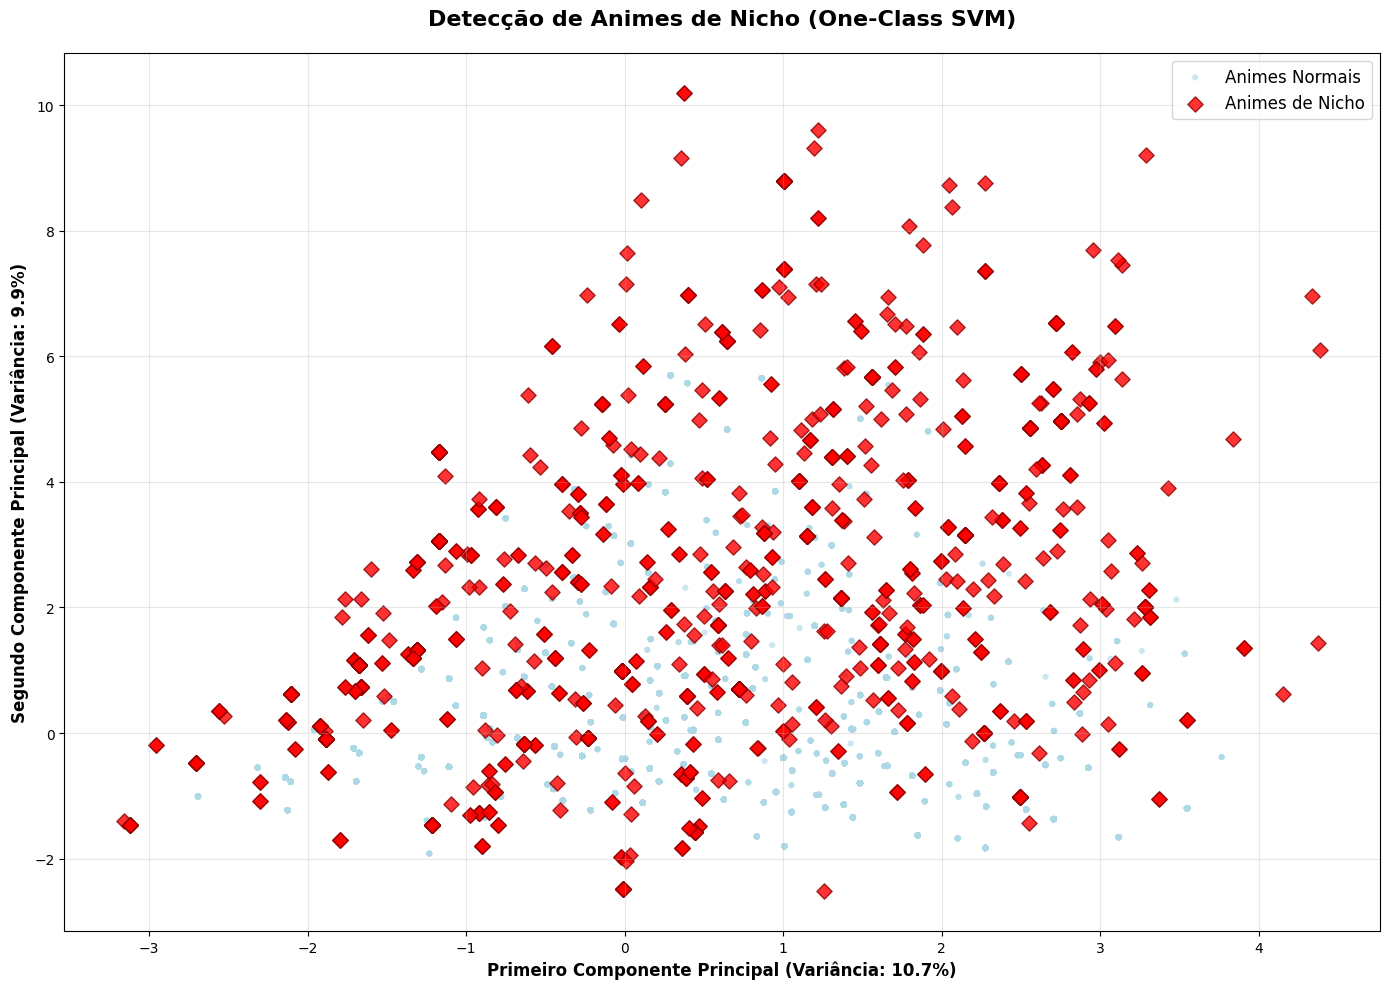

In [ ]:
# Aplicar PCA para visualização em 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print(f"Variância explicada pelo PC1: {pca.explained_variance_ratio_[0]:.3f}")
print(f"Variância explicada pelo PC2: {pca.explained_variance_ratio_[1]:.3f}")
print(f"Variância total explicada: {sum(pca.explained_variance_ratio_):.3f}")

plt.figure(figsize=(14, 10))

# Plotar animes normais
inliers_mask = predictions == 1
plt.scatter(X_pca[inliers_mask, 0], X_pca[inliers_mask, 1], 
            c='lightblue', alpha=0.6, s=20, label='Animes Normais', edgecolors='none')

# Plotar animes de nicho
outliers_mask = predictions == -1
plt.scatter(X_pca[outliers_mask, 0], X_pca[outliers_mask, 1], 
            c='red', alpha=0.8, s=60, label='Animes de Nicho', 
            edgecolors='darkred', linewidth=1, marker='D')

# Configurar gráfico
plt.xlabel(f'Primeiro Componente Principal (Variância: {pca.explained_variance_ratio_[0]:.1%})', 
            fontsize=12, fontweight='bold')
plt.ylabel(f'Segundo Componente Principal (Variância: {pca.explained_variance_ratio_[1]:.1%})', 
            fontsize=12, fontweight='bold')
plt.title('Detecção de Animes de Nicho (One-Class SVM)', 
            fontsize=16, fontweight='bold', pad=20)

plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(os.path.join(OUTPUT_PATH, 'nb3_outliers_pca.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

Esse gráfico nos mostra que os animes de nichos estão bem misturados aos animes considerados "normais", em questão de gêneros. Essa analise mostra que esses outliers podem estar afetando consideravelmente as analises feitas anteriormente nos notebooks nb01.ipynb e nb02.ipynb.

### Distribuição dos Decision Scores

O Decision Score é um valor numérico que indica quão "anômalo" ou diferente um ponto de dados é em relação aos dados normais.
- Valores negativos: Mais anômalos/outliers (mais longe da fronteira de decisão)
- Valores positivos: Mais normais/inliers (dentro da região normal)
> Quanto mais negativo, mais único/raro é o anime

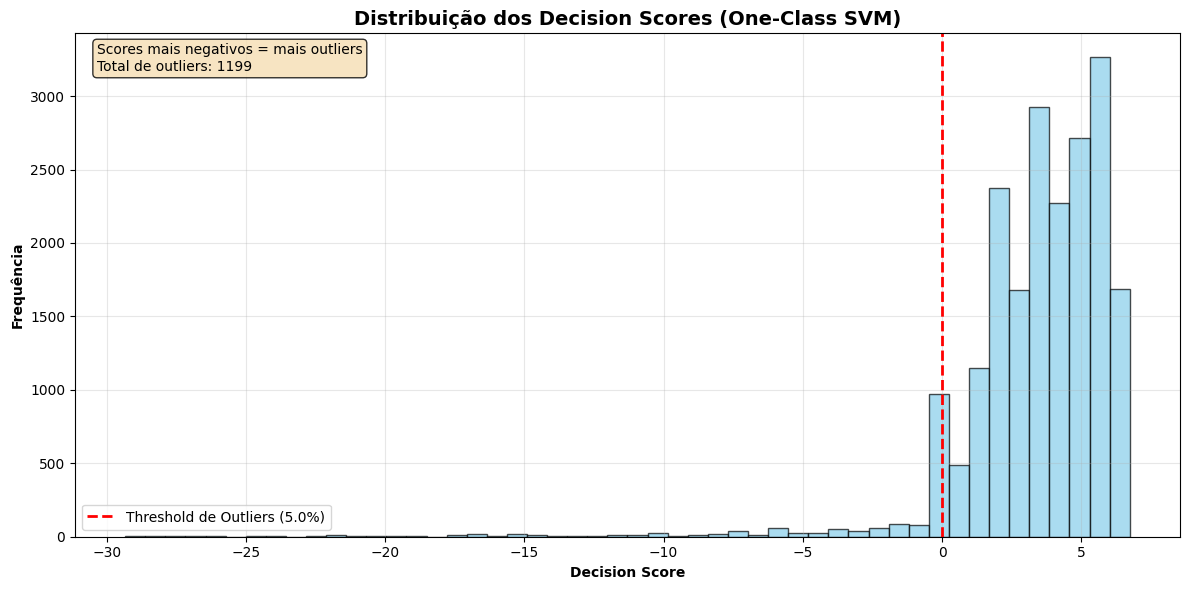

In [ ]:
plt.figure(figsize=(12, 6))

# Histograma dos scores
plt.hist(decision_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

# Marcar threshold de outliers
threshold = np.percentile(decision_scores, nu_value * 100)
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, 
            label=f'Threshold de Outliers ({nu_value*100}%)')

plt.xlabel('Decision Score', fontweight='bold')
plt.ylabel('Frequência', fontweight='bold')
plt.title('Distribuição dos Decision Scores (One-Class SVM)', 
            fontweight='bold', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Adicionar texto explicativo
plt.text(0.02, 0.98, 
            f'Scores mais negativos = mais outliers\nTotal de outliers: {sum(predictions == -1)}', 
            transform=plt.gca().transAxes, 
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
            fontsize=10)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'nb3_decision_scores_distribution.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

### Exemplos de aplicações

In [ ]:
# Utiliza os 5 animes mais outliers
top_outliers = animes_nicho.sort_values('decision_score').head(5)

for i, (idx, anime) in enumerate(top_outliers.iterrows()):
    print(f"{i+1}. {anime['title']}")
    year_str = f" {int(anime['year'])}" if pd.notna(anime['year']) else ""
    print(f"   Ano:{year_str} | Decision Score: {anime['decision_score']:.3f}")
    
    # Mostrar gêneros presentes
    generos_presentes = []
    for genero in colunas_generos:
        if anime[genero] == 1:
            generos_presentes.append(genero)
    
    print(f"   Gêneros: {', '.join(generos_presentes)}")
    print("-"*90)

1. Perfect Blue
   Ano: 1998 | Decision Score: -29.335
   Gêneros: Avant Garde, Award Winning, Drama, Horror, Suspense
------------------------------------------------------------------------------------------
2. Memories
   Ano: 1995 | Decision Score: -28.785
   Gêneros: Award Winning, Drama, Horror, Sci-Fi, Suspense
------------------------------------------------------------------------------------------
3. Paranoia Agent
   Ano: 2004 | Decision Score: -28.317
   Gêneros: Avant Garde, Award Winning, Drama, Mystery, Supernatural, Suspense
------------------------------------------------------------------------------------------
4. Airy Me
   Ano: 2013 | Decision Score: -28.257
   Gêneros: Avant Garde, Award Winning, Drama, Horror
------------------------------------------------------------------------------------------
5. Serial Experiments Lain
   Ano: 1998 | Decision Score: -28.198
   Gêneros: Avant Garde, Award Winning, Drama, Mystery, Sci-Fi, Supernatural, Suspense
--------------

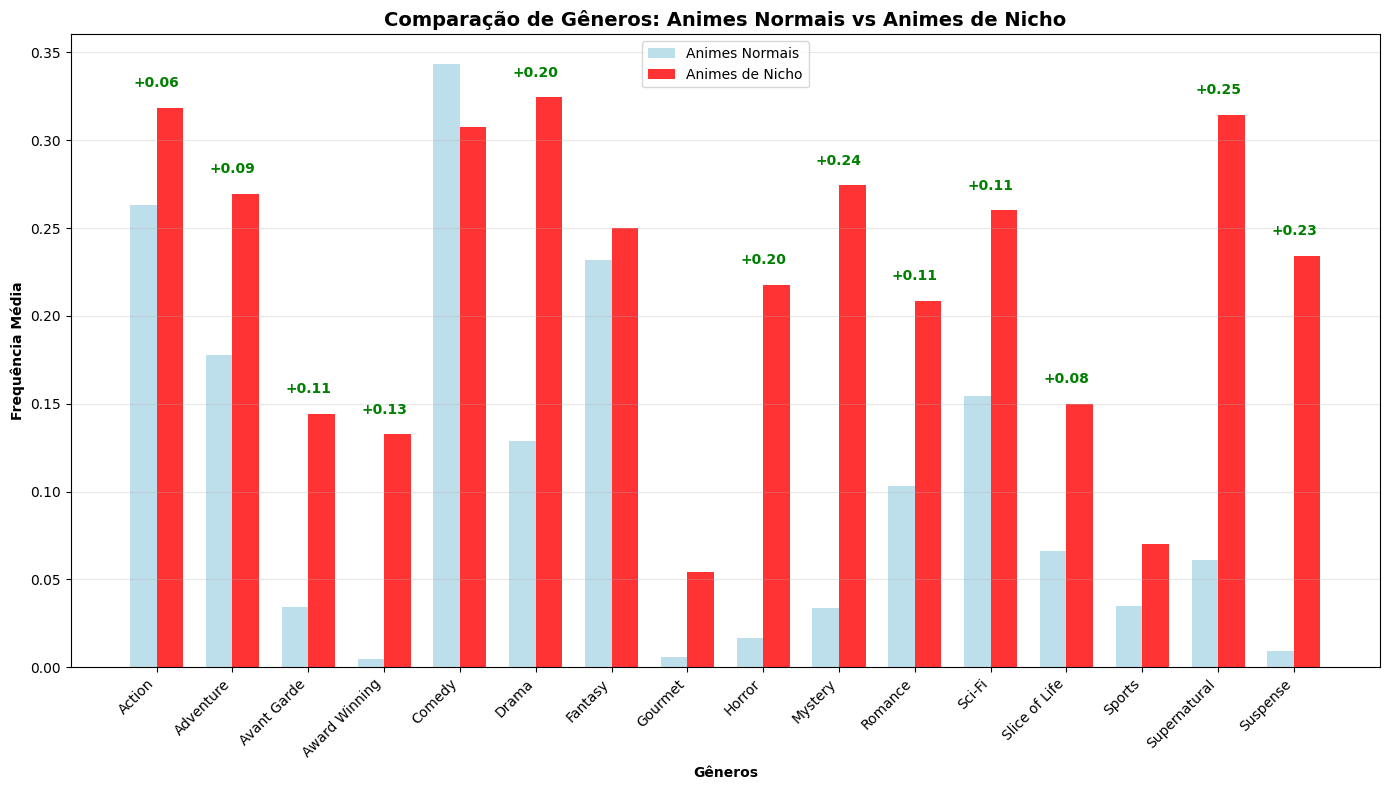

In [ ]:
# Criar gráfico de barras comparando gêneros entre animes normais e de nicho
fig, ax = plt.subplots(figsize=(14, 8))

# Preparar dados para o gráfico
x_pos = np.arange(len(colunas_generos))
width = 0.35

# Frequências médias
freq_normais = animes_normais[colunas_generos].mean().values
freq_nicho = animes_nicho[colunas_generos].mean().values

# Criar barras
bars1 = ax.bar(x_pos - width/2, freq_normais, width, 
                label='Animes Normais', color='lightblue', alpha=0.8)
bars2 = ax.bar(x_pos + width/2, freq_nicho, width, 
                label='Animes de Nicho', color='red', alpha=0.8)

# Configurar gráfico
ax.set_xlabel('Gêneros', fontweight='bold')
ax.set_ylabel('Frequência Média', fontweight='bold')
ax.set_title('Comparação de Gêneros: Animes Normais vs Animes de Nicho', 
            fontweight='bold', fontsize=14)
ax.set_xticks(x_pos)
ax.set_xticklabels(colunas_generos, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Destacar diferenças significativas
for i, (normal, nicho) in enumerate(zip(freq_normais, freq_nicho)):
    diff = abs(nicho - normal)
    if diff > 0.05:  # Diferença significativa
        max_val = max(normal, nicho)
        ax.text(i, max_val + 0.01, f'{diff:+.2f}', 
                ha='center', va='bottom', fontweight='bold', 
                color='green' if nicho > normal else 'orange')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH, 'nb3_generos_comparacao.png'), 
            dpi=300, bbox_inches='tight')
plt.show()

**Principais Descobertas:**

1. **Detecção Eficaz de Outliers**: O algoritmo identificou aproximadamente 6% dos animes como outliers (5.92%), que representam obras com características muito diferentes da maioria.

2. **Combinações Raras de Gêneros**: Os animes de nicho frequentemente apresentam:
   - Gêneros únicos ou muito específicos
   - Combinações incomuns de múltiplos gêneros
   - Ausência de gêneros muito populares (como Comedy ou Action)

**Resposta à Pergunta: "É possivel encontrar outliers pelos generos dos animes?"**:   
Sim, existem animes com combinações de gêneros extremamente raras! O One-Class SVM identificou obras que se desviam significativamente dos padrões convencionais, seja por usar gêneros pouco explorados, combinar gêneros de forma inusual, ou focar em nichos muito específicos.

**Outras Aplicações Práticas**:
- **Descoberta de Conteúdo**: Ajuda fãs a encontrar animes verdadeiramente únicos
- **Análise de Mercado**: Identifica nichos pouco explorados para novos projetos
- **Curadoria**: Permite criar listas de animes "alternativos" ou "experimentais"
- **Sistemas de Recomendação**: Pode sugerir conteúdo para usuários que buscam algo diferente